In [1]:
import sys
sys.path.append('../..')

import os
import json
import qiskit
import warnings
import pandas as pd
import numpy as np
import rustworkx as rx
from typing import List
from natsort import natsorted
from phoenix.models import HamiltonianModel
from phoenix.utils import arch
from qiskit.transpiler import CouplingMap
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
Manhattan = CouplingMap(arch.read_device_topology('../manhattan.graphml').to_directed().edge_list())
All2all = CouplingMap(rx.generators.complete_graph(35).to_directed().edge_list())
json_dpath = '../../benchmarks/qaoa_json'

**2QAN results on Manhattan:**

```
../../benchmarks/qaoa_text/qaoa_rand_16.txt CNOT gate count by 2QAN: 190
../../benchmarks/qaoa_text/qaoa_rand_20.txt CNOT gate count by 2QAN: 229
../../benchmarks/qaoa_text/qaoa_rand_24.txt CNOT gate count by 2QAN: 294
../../benchmarks/qaoa_text/qaoa_reg3_16.txt CNOT gate count by 2QAN: 178
../../benchmarks/qaoa_text/qaoa_reg3_20.txt CNOT gate count by 2QAN: 191
../../benchmarks/qaoa_text/qaoa_reg3_24.txt CNOT gate count by 2QAN: 250
```


In [4]:

fnames = ['qaoa_rand_16', 'qaoa_rand_20', 'qaoa_rand_24', 'qaoa_reg3_16', 'qaoa_reg3_20', 'qaoa_reg3_24']
num_2q_2qan = []
depth_2q_2qan = []
for fname in fnames:
    fname = os.path.join('./2qan', fname + '.qasm')
    qc = qiskit.QuantumCircuit.from_qasm_file(fname)
    num_2q_2qan.append(qc.num_nonlocal_gates())
    depth_2q_2qan.append(qc.depth(lambda instr: instr.operation.num_qubits > 1))


In [4]:
num_2q_2qan

[170, 219, 274, 148, 186, 223]

In [5]:
depth_2q_2qan

[85, 89, 100, 61, 48, 64]

In [8]:
def qiskit_O3_all2all(circ: qiskit.QuantumCircuit) -> qiskit.QuantumCircuit:
    from itertools import combinations
    for q0, q1 in combinations(range(circ.num_qubits), 2):
        circ.cx(q0, q1)
        circ.cx(q0, q1)
    circ = qiskit.transpile(circ, optimization_level=3, basis_gates=['u1', 'u2', 'u3', 'cx'])
    return circ

def is_all2all_coupling_map(coupling_map: CouplingMap) -> bool:
    # ! coupling_map.graph is a directed coupling map
    if coupling_map.size() * (coupling_map.size() - 1) == len(coupling_map.get_edges()):
        return True
    return False

def phoenix_pass(paulis: List[str], coeffs: List[float], coupling_map: CouplingMap) -> qiskit.QuantumCircuit:
    """Phoenix's high-level optimization"""
    ham = HamiltonianModel(paulis, coeffs)
    # circ = ham.reconfigure_and_generate_circuit() # this is the old version
    circ = ham.phoenix_circuit()


    circ = qiskit_O3_all2all(circ.to_qiskit())  # since input is logical circuit, we can first ally a all2all Qiskit O3
    if is_all2all_coupling_map(coupling_map):
        return circ
    circ = qiskit.transpile(circ, optimization_level=3,
                            basis_gates=['u1', 'u2', 'u3', 'cx'],
                            coupling_map=coupling_map, layout_method='sabre')
    return circ


def phoenix_pass_num_swap(paulis, coeffs, coupling_map):
    ham = HamiltonianModel(paulis, coeffs)
    # circ = ham.reconfigure_and_generate_circuit() # this is the old version
    circ = ham.phoenix_circuit()

    circ = qiskit_O3_all2all(circ.to_qiskit())  # since input is logical circuit, we can first ally a all2all Qiskit O3

    circ = qiskit.transpile(circ, optimization_level=3,
                            basis_gates=['u1', 'u2', 'u3', 'cx', 'swap'],
                            coupling_map=coupling_map, layout_method='sabre')
    return circ.count_ops()['swap']

In [9]:
num_2q_phoenix = []
depth_2q_phoenix = []
for fname in fnames:
    fname = os.path.join(json_dpath, fname + '.json')
    with open(fname, 'r') as f:
        data = json.load(f)
    
    circ = phoenix_pass(data['paulis'], data['coeffs'], Manhattan)
    num_2q_phoenix.append(circ.num_nonlocal_gates())
    depth_2q_phoenix.append(circ.depth(lambda instr: instr.operation.num_qubits > 1))



In [10]:
depth_2q_phoenix

[45, 50, 63, 30, 23, 33]

In [11]:
num_2q_phoenix

[148, 191, 255, 100, 119, 156]

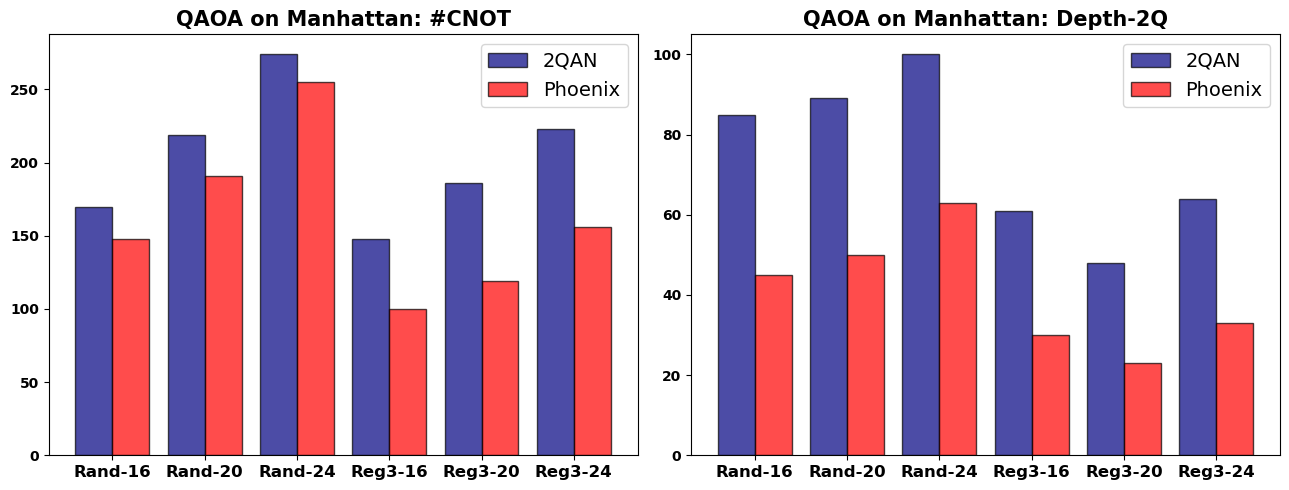

In [12]:
plt.figure(figsize=(13, 5))


plt.subplot(1, 2, 1)
width = 0.4
xticks = [fname.replace('qaoa_', '').replace('_', '-').capitalize() for fname in fnames]
plt.bar(np.arange(len(xticks)) - 0.5 * width, num_2q_2qan, width=width, label='2QAN', color='navy', alpha=0.7, edgecolor='black')
plt.bar(np.arange(len(xticks)) + 0.5 * width, num_2q_phoenix, width=width, label='Phoenix', color='red', alpha=0.7, edgecolor='black')
plt.xticks(range(len(xticks)), xticks, fontsize=12, fontweight='bold')
plt.legend(fontsize=14, loc='upper right')
plt.yticks(fontweight='bold')
plt.title('QAOA on Manhattan: #CNOT', fontsize=15, fontweight='bold')

plt.subplot(1, 2, 2)
plt.bar(np.arange(len(xticks)) - 0.5 * width, depth_2q_2qan, width=width, label='2QAN', color='navy', alpha=0.7, edgecolor='black')
plt.bar(np.arange(len(xticks)) + 0.5 * width, depth_2q_phoenix, width=width, label='Phoenix', color='red', alpha=0.7, edgecolor='black')
plt.xticks(range(len(xticks)), xticks, fontsize=12, fontweight='bold')
plt.legend(fontsize=14, loc='upper right')
plt.yticks(fontweight='bold')
plt.title('QAOA on Manhattan: Depth-2Q', fontsize=15, fontweight='bold')


plt.tight_layout()
# plt.savefig('../figures/qaoa.pdf')


In [13]:
for fname in fnames:
    json_fname = os.path.join(json_dpath, fname + '.json')
    with open(json_fname, 'r') as f:
        data = json.load(f)

    ham = HamiltonianModel(data['paulis'], data['coeffs'])
    circ = ham.generate_circuit()

    print(fname, data['num_qubits'], len(data['paulis']), circ.num_nonlocal_gates, circ.depth_nonlocal)

qaoa_rand_16 16 32 64 36
qaoa_rand_20 20 40 80 32
qaoa_rand_24 24 48 96 48
qaoa_reg3_16 16 24 48 18
qaoa_reg3_20 20 30 60 22
qaoa_reg3_24 24 36 72 20


### Detailed data for table

In [52]:
result_2qan = pd.DataFrame(columns=['fname', 'num_qubits', 'num_paulis',
                                    'num_cnot(all2all)', 'depth_2q(all2all)',
                                    'num_cnot(manhattan)', 'depth_2q(manhattan)',
                                    'num_swap(manhatten)'])
result_phoenix = pd.DataFrame(columns=['fname', 'num_qubits', 'num_paulis',
                                       'num_cnot(all2all)', 'depth_2q(all2all)',
                                       'num_cnot(manhattan)', 'depth_2q(manhattan)',
                                       'num_swap(manhatten)'])
for fname in fnames:
    json_fname = os.path.join(json_dpath, fname + '.json')
    with open(json_fname, 'r') as f:
        data = json.load(f)

    ham = HamiltonianModel(data['paulis'], data['coeffs'])
    circ = ham.generate_circuit()

    result_2qan = pd.concat([result_2qan, pd.DataFrame({'fname': fname, 'num_qubits': data['num_qubits'], 'num_paulis': len(data['paulis'])}, index=[0])], ignore_index=True)
    result_phoenix = pd.concat([result_phoenix, pd.DataFrame({'fname': fname, 'num_qubits': data['num_qubits'], 'num_paulis': len(data['paulis'])}, index=[0])], ignore_index=True)


In [ ]:
np.random.seed(123)
for fname in fnames:
    json_fname = os.path.join(json_dpath, fname + '.json')
    with open(json_fname, 'r') as f:
        data = json.load(f)

    # all2all mapping
    circ = phoenix_pass(data['paulis'], data['coeffs'], coupling_map=All2all)
    result_phoenix.loc[result_phoenix['fname'] == fname, 'num_cnot(all2all)'] = circ.num_nonlocal_gates()
    result_phoenix.loc[result_phoenix['fname'] == fname, 'depth_2q(all2all)'] = circ.depth(lambda instr: instr.operation.num_qubits > 1)
    
    # manhattan mapping
    num_cnot = []
    depth_2q = []
    for _ in range(50):
        circ = phoenix_pass(data['paulis'], data['coeffs'], coupling_map=Manhattan)
        num_cnot.append(circ.num_nonlocal_gates())
        depth_2q.append(circ.depth(lambda instr: instr.operation.num_qubits > 1))
    result_phoenix.loc[result_phoenix['fname'] == fname, 'num_cnot(manhattan)'] = np.mean(num_cnot).astype(int)
    result_phoenix.loc[result_phoenix['fname'] == fname, 'depth_2q(manhattan)'] = np.mean(depth_2q).astype(int)
    num_swap = []
    for _ in range(50):
        num_swap.append(phoenix_pass_num_swap(data['paulis'], data['coeffs'], coupling_map=Manhattan))
    result_phoenix.loc[result_phoenix['fname'] == fname, 'num_swap(manhatten)'] = np.mean(num_swap).astype(int)

In [63]:
result_phoenix['num_cnot(manhattan)'] = result_phoenix['num_cnot(manhattan)'].astype(int)
result_phoenix['depth_2q(manhattan)'] = result_phoenix['depth_2q(manhattan)'].astype(int)
result_phoenix['num_swap(manhatten)'] = result_phoenix['num_swap(manhatten)'].astype(int)

In [67]:
result_phoenix

,fname,num_qubits,num_paulis,num_cnot(all2all),depth_2q(all2all),num_cnot(manhattan),depth_2q(manhattan),num_swap(manhatten)
0,qaoa_rand_16,16,32,64,18,150,52,29
1,qaoa_rand_20,20,40,80,14,187,49,39
2,qaoa_rand_24,24,48,96,16,257,67,56
3,qaoa_reg3_16,16,24,48,8,99,28,17
4,qaoa_reg3_20,20,30,60,8,128,30,23
5,qaoa_reg3_24,24,36,72,8,158,34,30


In [68]:
result_phoenix.to_csv('qaoa_phoexix.csv', index=False)

In [17]:
for fname in fnames:
    json_fname = os.path.join(json_dpath, fname + '.json')
    with open(json_fname, 'r') as f:
        data = json.load(f)

    # all2all mapping
    circ = phoenix_pass(data['paulis'], data['coeffs'], coupling_map=All2all)
    # result_phoenix.loc[result_phoenix['fname'] == fname, 'num_cnot(all2all)'] = circ.num_nonlocal_gates()
    # result_phoenix.loc[result_phoenix['fname'] == fname, 'depth_2q(all2all)'] = circ.depth(lambda instr: instr.operation.num_qubits > 1)
    print(fname, circ.num_nonlocal_gates(), circ.depth(lambda instr: instr.operation.num_qubits > 1))
    

qaoa_rand_16 64 18
qaoa_rand_20 80 14
qaoa_rand_24 96 16
qaoa_reg3_16 48 8
qaoa_reg3_20 60 8
qaoa_reg3_24 72 8


In [60]:
result_phoenix

,fname,num_qubits,num_paulis,num_cnot(all2all),depth_2q(all2all),num_cnot(manhattan),depth_2q(manhattan),num_swap(manhatten)
0,qaoa_rand_16,16,32,64,18,150.32,52.02,29.46
1,qaoa_rand_20,20,40,80,14,187.86,49.50,39.18
2,qaoa_rand_24,24,48,96,16,257.36,67.46,56.28
3,qaoa_reg3_16,16,24,48,8,99.02,28.84,17.40
4,qaoa_reg3_20,20,30,60,8,128.54,30.10,23.68
5,qaoa_reg3_24,24,36,72,8,158.20,34.80,30.28


### Read files

In [5]:
result_phoenix = pd.read_csv('qaoa_phoexix.csv')
result_2qan = pd.read_csv('qaoa_2qan.csv')

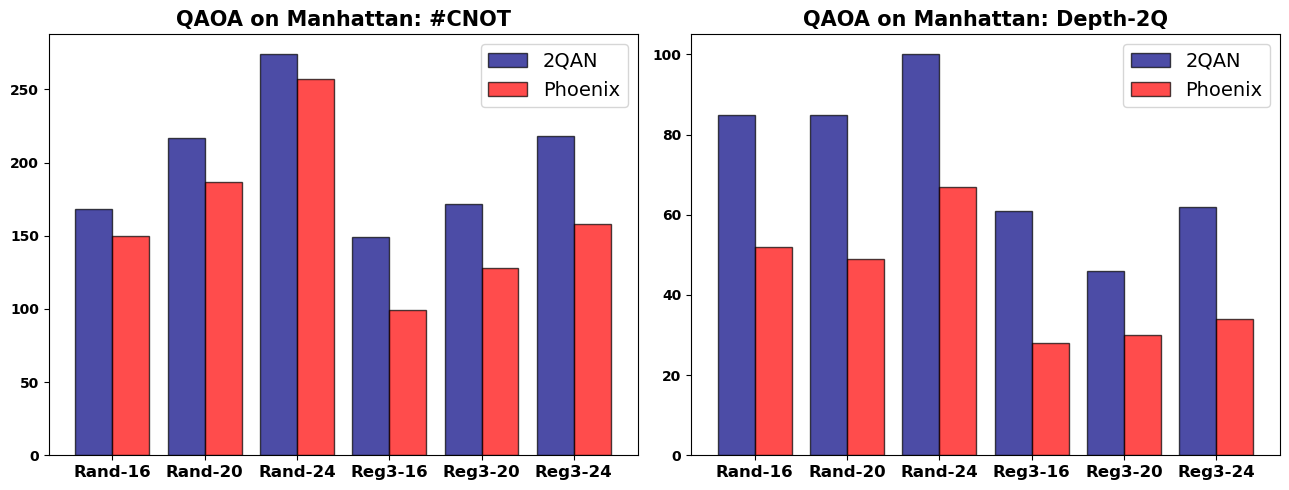

In [ ]:
plt.figure(figsize=(13, 5))


plt.subplot(1, 2, 1)
width = 0.4
xticks = [fname.replace('qaoa_', '').replace('_', '-').capitalize() for fname in fnames]
plt.bar(np.arange(len(xticks)) - 0.5 * width, result_2qan['num_cnot(manhattan)'], width=width, label='2QAN', color='navy', alpha=0.7, edgecolor='black')
plt.bar(np.arange(len(xticks)) + 0.5 * width, result_phoenix['num_cnot(manhattan)'], width=width, label='Phoenix', color='red', alpha=0.7, edgecolor='black')
plt.xticks(range(len(xticks)), xticks, fontsize=12, fontweight='bold')
plt.legend(fontsize=14, loc='upper right')
plt.yticks(fontweight='bold')
plt.title('QAOA on Manhattan: #CNOT', fontsize=15, fontweight='bold')

plt.subplot(1, 2, 2)
plt.bar(np.arange(len(xticks)) - 0.5 * width, result_2qan['depth_2q(manhattan)'], width=width, label='2QAN', color='navy', alpha=0.7, edgecolor='black')
plt.bar(np.arange(len(xticks)) + 0.5 * width, result_phoenix['depth_2q(manhattan)'], width=width, label='Phoenix', color='red', alpha=0.7, edgecolor='black')
plt.xticks(range(len(xticks)), xticks, fontsize=12, fontweight='bold')
plt.legend(fontsize=14, loc='upper right')
plt.yticks(fontweight='bold')
plt.title('QAOA on Manhattan: Depth-2Q', fontsize=15, fontweight='bold')


plt.tight_layout()
# plt.savefig('../figures/qaoa.pdf')


In [21]:
from scipy.stats import gmean
print('num_cnot reduction', gmean(1 - result_phoenix['num_cnot(manhattan)'] / result_2qan['num_cnot(manhattan)']).round(4))
print('depth_2q reduction', gmean(1 - result_phoenix['depth_2q(manhattan)'] / result_2qan['depth_2q(manhattan)']).round(4))
print('num_swap reduction', gmean(1 - result_phoenix['num_swap(manhatten)'] / result_2qan['num_swap(manhatten)']).round(4))
print('routing overhead', gmean(1 - result_phoenix['routing_overhead'] / result_2qan['routing_overhead']).round(4))

num_cnot reduction 0.167
depth_2q reduction 0.408
num_swap reduction 0.2941
routing overhead 0.1659


In [19]:
result_phoenix['routing_overhead'] = round(result_phoenix['num_cnot(manhattan)'] / result_phoenix['num_cnot(all2all)'], 2)
result_phoenix

,fname,num_qubits,num_paulis,num_cnot(all2all),depth_2q(all2all),num_cnot(manhattan),depth_2q(manhattan),num_swap(manhatten),routing_overhead
0,qaoa_rand_16,16,32,64,18,150,52,29,2.34
1,qaoa_rand_20,20,40,80,14,187,49,39,2.34
2,qaoa_rand_24,24,48,96,16,257,67,56,2.68
3,qaoa_reg3_16,16,24,48,8,99,28,17,2.06
4,qaoa_reg3_20,20,30,60,8,128,30,23,2.13
5,qaoa_reg3_24,24,36,72,8,158,34,30,2.19


In [20]:
result_2qan['routing_overhead'] = round(result_2qan['num_cnot(manhattan)'] / result_2qan['num_cnot(all2all)'], 2)
result_2qan

,fname,num_qubits,num_paulis,num_cnot(all2all),depth_2q(all2all),num_cnot(manhattan),depth_2q(manhattan),num_swap(manhatten),routing_overhead
0,qaoa_rand_16,16,32,64,18,168,85,37,2.62
1,qaoa_rand_20,20,40,80,14,217,85,47,2.71
2,qaoa_rand_24,24,48,96,14,274,100,63,2.85
3,qaoa_reg3_16,16,24,48,10,149,61,44,3.10
4,qaoa_reg3_20,20,30,60,8,172,46,46,2.87
5,qaoa_reg3_24,24,36,72,8,218,62,62,3.03


In [27]:
comparison = pd.merge(
    result_2qan, result_phoenix,
    on=['fname', 'num_qubits', 'num_paulis'],
    suffixes=('(2qan)', '(phoenix)')
)

In [34]:
df_part = comparison[['fname', 'num_qubits', 'num_paulis',
            'num_cnot(manhattan)(2qan)', 'num_cnot(manhattan)(phoenix)', 
            'depth_2q(manhattan)(2qan)', 'depth_2q(manhattan)(phoenix)',
            'num_swap(manhatten)(2qan)', 'num_swap(manhatten)(phoenix)',
            'routing_overhead(2qan)', 'routing_overhead(phoenix)']]
df_part

,fname,num_qubits,num_paulis,num_cnot(manhattan)(2qan),num_cnot(manhattan)(phoenix),depth_2q(manhattan)(2qan),depth_2q(manhattan)(phoenix),num_swap(manhatten)(2qan),num_swap(manhatten)(phoenix),routing_overhead(2qan),routing_overhead(phoenix)
0,qaoa_rand_16,16,32,168,150,85,52,37,29,2.62,2.34
1,qaoa_rand_20,20,40,217,187,85,49,47,39,2.71,2.34
2,qaoa_rand_24,24,48,274,257,100,67,63,56,2.85,2.68
3,qaoa_reg3_16,16,24,149,99,61,28,44,17,3.10,2.06
4,qaoa_reg3_20,20,30,172,128,46,30,46,23,2.87,2.13
5,qaoa_reg3_24,24,36,218,158,62,34,62,30,3.03,2.19


In [36]:
df_part.to_latex('qaoa.tex', index=False)

In [69]:
np.random.seed(123)

json_fname = os.path.join(json_dpath, 'qaoa_rand_16' + '.json')
with open(json_fname, 'r') as f:
    data = json.load(f)

# all2all mapping
circ = phoenix_pass(data['paulis'], data['coeffs'], coupling_map=All2all)
   

In [70]:
circ.draw(fold=300)

global phase: 3.7021
                                                                                                                                                                                                                                                                                                   »
 q_0: ──■─────────────────────────────■──────────────────────────────────────────────────────────────────────────■─────────────────────────────────────────────────■──────────────────────────────────■───────────────────────────────────────■─────────■──────────────────────────────────────────»
        │                             │                                                                          │                                                 │                                  │                                       │         │                                          »
 q_1: ──┼────■────────────────────────┼─────────■────────────────────────■───────────────────────────────────────┼──────────────────────────────────■──────────────┼──────────────────────────────────┼───────────────────────────────────────┼─────────┼───────────────────■──────────────────────»
      ┌─┴─┐  │  ┌─────────────┐     ┌─┴─┐       │                        │                                       │                                  │              │                                  │                                       │         │                   │                      »
 q_2: ┤ X ├──┼──┤ U1(0.94672) ├─────┤ X ├───────┼───────────────────■────┼───────────────────────────────────────┼────────────────────────■─────────┼──────────────┼─────────■────────────────────────┼─────────────────────────────■─────────┼─────────┼─────────■─────────┼──────────────────────»
      └───┘  │  └─────────────┘     └───┘       │                   │    │                                       │                        │         │              │         │                        │                             │         │         │         │         │                      »
 q_3: ───────┼─────────■────────────────────────┼─────────■─────────┼────┼───────────────────────────────────────┼────■───────────────────┼─────────┼──────────────┼────■────┼────────────────────────┼─────────────────────────────┼─────────┼─────────┼─────────┼─────────┼─────────■────────────»
             │         │                        │         │         │    │                                       │    │                   │         │              │    │    │                        │                             │         │         │         │         │         │            »
 q_4: ──■────┼─────────┼────────────────────────┼────■────┼─────────┼────┼──────────────────────────────────■────┼────┼───────────────────┼─────────┼─────────■────┼────┼────┼────────────────────────┼─────────────────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────»
        │  ┌─┴─┐       │       ┌─────────────┐┌─┴─┐  │    │         │    │                                  │    │    │                   │         │         │    │    │    │                        │                             │         │         │         │         │         │            »
 q_5: ──┼──┤ X ├───────┼───────┤ U1(0.94672) ├┤ X ├──┼────┼─────────┼────┼─────────■────────────────────────┼────┼────┼───────────────────┼────■────┼─────────┼────┼────┼────┼─────────■──────────────┼─────────────────────────────┼────■────┼─────────┼─────────┼─────────┼─────────┼────────────»
        │  └───┘       │       └─────────────┘└───┘  │    │         │    │         │                        │    │    │                   │    │    │         │    │    │    │         │              │                             │    │    │         │         │         │         │            »
 q_6: ──┼────■─────────┼─────────────────────────────┼────┼────■────┼────┼─────────┼──────────────■─────────┼────┼────┼───────────────────┼────┼────┼────■────┼────┼────┼─